<a href="https://colab.research.google.com/github/ashkwart/Ashley-Website/blob/main/Week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%config InlineBackend.figure_formats = ["retina"]

# Week 7: Migration and relocation

In [3]:
!pip install -q geopandas networkx us census xlrd

In [4]:
import json

import geopandas as gpd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests
import us

from census import Census
from shapely.geometry import Point

In [5]:
census = Census("", year=2020)

## ACS migration flows

We'll use New York again for our starting point!

In [6]:
state_fips = "36"

We're going to pull straight from `census.gov`, but we'll include a backup link in case federal data goes down again.

In [7]:
# alternate source (Musk-proofing): https://web.archive.org/web/20241226165446if_/https://www2.census.gov/programs-surveys/demo/tables/geographic-mobility/2020/county-to-county-migration-2016-2020/county-to-county-migration-flows/Net_Gross_US.txt

raw_flows = requests.get(
    "https://www2.census.gov/programs-surveys/demo/tables/geographic-mobility/2020/county-to-county-migration-2016-2020/county-to-county-migration-flows/Net_Gross_US.txt"
).content.decode("latin1").split("\n")

Let's take a look at the first row.

In [8]:
raw_flows[0]

'001001001003 Alabama                       Autauga County                      Alabama                       Baldwin County                            30       37      489      395     -459      396      519      398 '

OK so that's kind of messy.  It's not even a CSV (which is comma-separated), but rather it's tab-separated.  And it doesn't even have column headers.  We'll do a little sleuthing.  First, we poked around and found a spreadsheet with equivalent data, and used that to supply column header names.  Here they are.  

In [9]:
# column names we figured out from finding an equivalent Excel spreadsheet
place_columns = (
    "a_fips",
    "b_fips",
    "a_state",
    "a_county",
    "b_state",
    "b_county",
)

flow_columns = (
    "b_to_a_flow_est",
    "b_to_a_flow_moe",
    "a_to_b_flow_est",
    "a_to_b_moe",
    "net_flow_est",
    "net_flow_moe",
    "gross_flow_est",
    "gross_flow_moe",
)

columns = (*place_columns, *flow_columns)

The next two cells pull the data together into a dataframe that's suitable for studying flows.  The first one uses the spaces to split things up, in particular.

In [10]:
flows = []
for raw_flow in raw_flows[:-1]:
    flow_id = raw_flow[:raw_flow.index(" ")]
    if not all(c.isdigit() for c in flow_id):
        continue  # skip non-county flows

    assert len(flow_id) == 12, flow_id
    a_fips = flow_id[1:6]
    b_fips = flow_id[7:]

    remainder = raw_flow[raw_flow.index(" "):]
    parts = [a_fips, b_fips] + [part.strip() for part in remainder.split("  ") if part.strip()]
    flows.append({col: val for col, val in zip(columns, parts)})

In [11]:
flow_df = pd.DataFrame(flows).set_index(["a_fips", "b_fips"])
for col in flow_columns:
    flow_df[col] = flow_df[col].astype(int)

This next cell is just an assert statement to make sure there are no null values.  (We do this by summing a bunch of values and checking that the total isn't `NaN`.)

In [12]:
assert not flow_df["a_to_b_flow_est"].isna().sum()

Grab the borough/county names....

In [13]:
nyc_county_fips_codes = {
    "The Bronx": "36005",      # Bronx County
    "Brooklyn": "36047",       # Kings County
    "Manhattan": "36061",      # New York County
    "Queens": "36081",         # Queens County
    "Staten Island": "36085",  # Richmond
}

Now we read in a county shapefile (and put it in the Atlas Equal-Area CRS).

In [14]:
county_gdf = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/COUNTY/tl_2020_us_county.zip").set_index("GEOID").to_crs("EPSG:2163")

Let's narrow that gdf down to the NYC counties.  We have a dictionary where the county names are the keys, followed by FIPS codes as the values.  Let's list those values.

In [15]:
print(nyc_county_fips_codes.values())

dict_values(['36005', '36047', '36061', '36081', '36085'])


That functions as a list.  When we filter the geodataframe by that list, it will give us the rows with those FIPS codes.

In [16]:
nyc_county_gdf = county_gdf.loc[nyc_county_fips_codes.values()]

Now, make the graph!  remember `nx` means NetworkX, which is the basic Python library for graphs.

In [17]:
migration_graph = nx.DiGraph()
net_migration_graph = nx.DiGraph()

for a_county, a_county_fips in nyc_county_fips_codes.items():
    for b_county, b_county_fips in nyc_county_fips_codes.items():
        if a_county == b_county:
            continue

        flow = flow_df.loc[(a_county_fips, b_county_fips)]
        net_flow = flow["net_flow_est"]
        if net_flow >= 0:
            net_migration_graph.add_edge(
                a_county,
                b_county,
                weight=net_flow,
            )
        else:
            net_migration_graph.add_edge(
                b_county,
                a_county,
                weight=-net_flow,
            )

This next bit is a technical step.  We're using a Python library called `Shapely` that lets us manipulate geographical shapes.  This is grabbing the Shapely `point` object for each county's internal point and converting it to coordinates so that there's a mapped point associated with each object (county).

In [18]:
def cast_point(p):
    return (p.xy[0][0], p.xy[1][0])

Now, plot it!  We suppress the axes (because those aren't helpful here) and choose some plotting details, then draw the shapes, points, and arrows for flows.

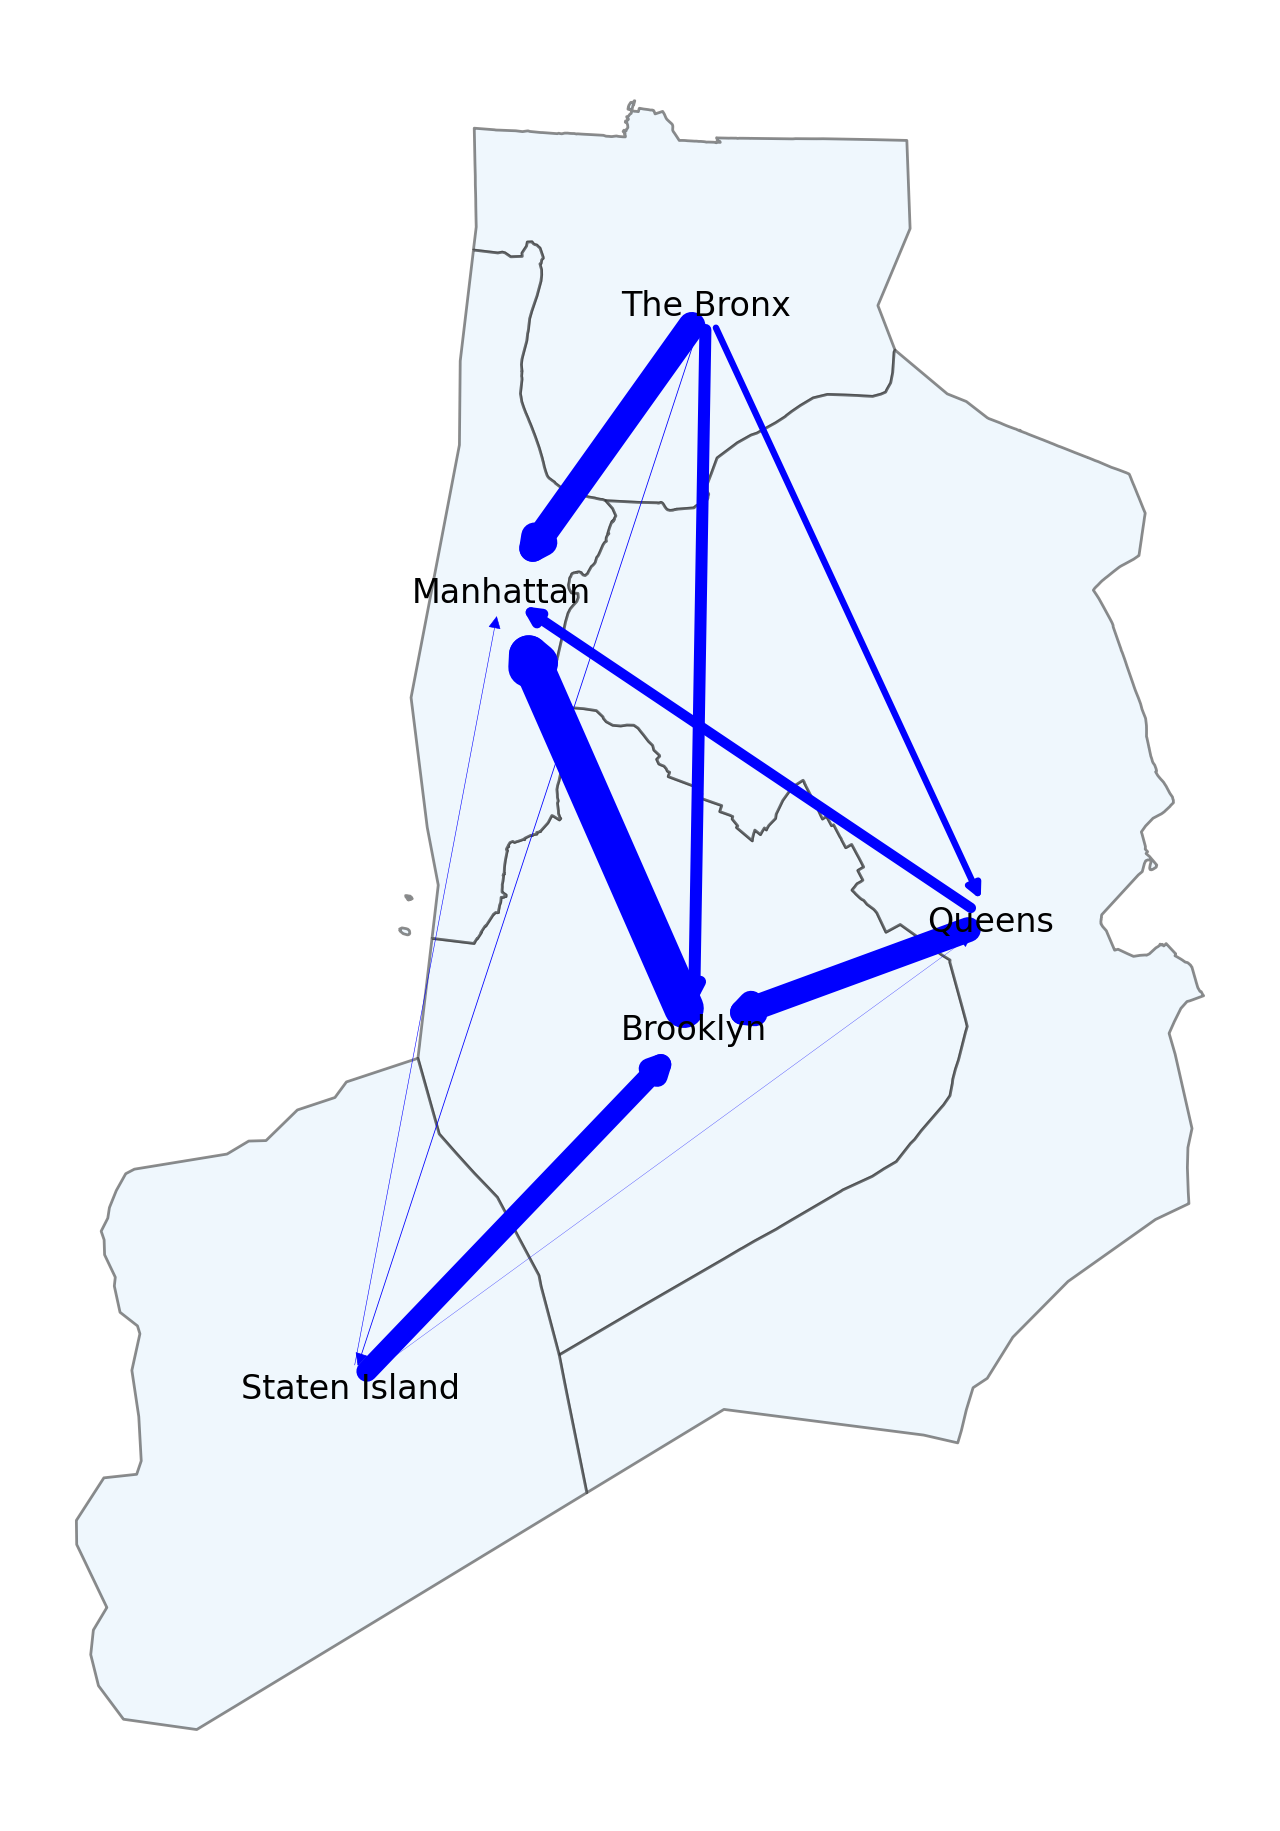

In [19]:
fig, ax = plt.subplots(figsize=(8, 16))
ax.axis("off")
nyc_county_gdf.plot(ax=ax, edgecolor="0.1", linewidth=1, color="#e1f1fd", alpha=0.5)

pos = {
    borough: cast_point(nyc_county_gdf.loc[county_fips].geometry.representative_point())
    for borough, county_fips in nyc_county_fips_codes.items()
}
#nx.draw_networkx_nodes(net_migration_graph, pos, ax=ax)
nx.draw_networkx_labels(net_migration_graph, pos, ax=ax)

for edge in net_migration_graph.edges(data='weight'):
    nx.draw_networkx_edges(net_migration_graph, pos, edgelist=[edge], width=0.0015 * edge[2], ax=ax, edge_color="blue")

# Migration with PUMS data

OK, so there's only so much we can do with the ACS data, which really is just numbers of people moving from one county to another.  If we want to drill down into race or other attributes, we should switch over to PUMS, or "public use microdata samples."  Let's pull in something called `rac1p` that records the correspondence between numerical codes found in the PUMS data and familiar race categories.

Important: PUMS is an extraordinary data source because since it's leveraging all the microdata, it lets you drill down way past these categories. Check out the [API docs](https://api.census.gov/data/2023/acs/acs1/pums/variables.html) for all the codes.  [RAC2P](https://api.census.gov/data/2023/acs/acs1/pums/variables/RAC2P.json) and [RAC3P](https://api.census.gov/data/2023/acs/acs1/pums/variables/RAC3P.json) are much more granular. But we're keeping it simple for now.

In [20]:
rac1p = {
    "1": "white",  # White alone
    "2": "black",  # Black or African American alone
    "3": "amin",   # "American Indian alone",
    "4": "amin",   # Alaska Native alone
    "5": "amin",   # "American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races",
    "6": "aapi",   # "Asian alone",
    "7": "aapi",   # "Native Hawaiian and Other Pacific Islander alone",
    "8": "other",  # "Some other race alone",
    "9": "two_or_more",  # "Two or More Races"
}

This next one will take a while (6 or 7 minutes or so in Colab). It populates the gdf with all the national data.  We'll have it print the state names as it processes them so we can get a kind of progress bar.

The geographical units for PUMS data are called [PUMAs](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/pumas.html), or Public Use Microdata Areas.  

In [23]:
pums_results = []
puma_gdfs = []

for state in us.states.STATES:
    print(state)

    state_pums_response = requests.get(
        "https://api.census.gov/data/2023/acs/acs1/pums"
        f"?get=MIGSP,MIGPUMA,RAC1P&for=public%20use%20microdata%20area:*&in=state:{state.fips}"
    ).json()
    pums_results += state_pums_response[1:]

    puma_gdfs.append(
        gpd.read_file(
            f"https://www2.census.gov/geo/tiger/TIGER2024/PUMA20/tl_2024_{state.fips}_puma20.zip"
        )
    )

# Note that you could add in other variables from the PUMS data in the line above.  For instance, this alternative gets RAC3P as well as RAC1P.
#        f"?get=MIGSP,MIGPUMA,RAC1P,RAC3P&for=public%20use%20microdata%20area:*&in=state:{state.fips}"

Alabama


ConnectTimeout: HTTPSConnectionPool(host='api.census.gov', port=443): Max retries exceeded with url: /data/2023/acs/acs1/pums?get=MIGSP,MIGPUMA,RAC1P&for=public%20use%20microdata%20area:*&in=state:01 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7ea724bc11d0>, 'Connection to api.census.gov timed out. (connect timeout=None)'))

In [ ]:
pumas_gdf = gpd.GeoDataFrame(pd.concat(puma_gdfs), crs=puma_gdfs[0].crs).set_index("GEOID20")

Still building the geodataframe -- one thing to notice is that we're using "internal points" provided by the Census Bureau as the location of the node associated to each PUMA.  (See [Census Glossary](https://www.census.gov/programs-surveys/geography/about/glossary.html))  These show up as `INTPLTLAT20` and `INTPTLON20`.

In [ ]:
puma_points_gdf = gpd.GeoDataFrame(
    {
        "geometry": pumas_gdf.apply(
            lambda row: Point(float(row["INTPTLON20"]), float(row["INTPTLAT20"])),
            axis=1,
        ),
        "name": pumas_gdf["NAMELSAD20"],
        "lat": pumas_gdf["INTPTLAT20"].astype(float),
        "lon": pumas_gdf["INTPTLON20"].astype(float),
    },
    crs=pumas_gdf.crs,
)

In [ ]:
puma_points_gdf

In [ ]:
excluded_migpumas = (
    "00001",  # Did not live in the United States or in Puerto Rico one year ago
    "00002",  # Lived in Puerto Rico one year ago and current residence is in the United States
    "N",      # N/A (person less than 1 year old/lived in same house 1 year ago)
)

In [ ]:
puma_df = pd.DataFrame(pums_results, columns=["migsp", "migpuma", "race", "state", "puma"])
puma_df["race"] = puma_df["race"].map(rac1p)

# If you wanted more variables from PUMS, you can do that something like this.
# puma_df = pd.DataFrame(pums_results, columns=["migsp", "migpuma", "rac1p", "rac3p" "state", "puma"])
# puma_df["rac1p"] = puma_df["rac1p"].map(rac1p) # codes -> labels
# puma_df["rac3p"] = puma_df["rac3p"].map(rac3p) # likewise, codes -> labels

In [ ]:
puma_flows_df = puma_df[puma_df["migsp"].str.startswith("0")].copy()
puma_flows_df["from"] = puma_flows_df["migsp"].str.slice(1) + puma_flows_df["migpuma"]
puma_flows_df["to"] = puma_df["state"] + puma_flows_df["puma"]
puma_flows_df = puma_flows_df[["from", "to", "race"]]
puma_flows_df

In [ ]:
state_gdf = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2024/STATE/tl_2024_us_state.zip").set_index("GEOID").to_crs("EPSG:2163")

In [ ]:
proj_puma_points = dict(puma_points_gdf.to_crs("EPSG:2163")["geometry"])

Let's take a look at flows in and out of one state in a static map.  We'll choose California (FIPS code 06).

In [ ]:
flow_state = "06"

In [ ]:
for race in puma_flows_df["race"].unique():
        race_flows_df = puma_flows_df[puma_flows_df["race"] == race]
        in_flow_counts = race_flows_df[race_flows_df["to"].str.startswith(flow_state)].groupby(by=["from", "to"]).size()
        out_flow_counts = race_flows_df[race_flows_df["from"].str.startswith(flow_state)].groupby(by=["from", "to"]).size()

        ax = state_gdf.plot(
            figsize=(20, 10),
            edgecolor="0.1",
            linewidth=0.4,
            color="#e1f1fd",
        )

        for flow_counts, color in zip((in_flow_counts, out_flow_counts), ("red", "blue")):
            for (flow_from, flow_to), count in flow_counts.items():
                try:
                    from_x, from_y = proj_puma_points[flow_from].coords.xy
                    to_x, to_y = proj_puma_points[flow_to].coords.xy
                except KeyError:
                    continue

                ax.plot([from_x[0], to_x[0]], [from_y[0], to_y[0]], color=color, linewidth=0.5 * count, alpha=0.3)

        ax.axis("off")
        ax.set_title(f"{race} migration (in: red, out: blue)")
        plt.show()

## Let's make a FlowmapBlue

Same as before, we'll set up some Google credentials to use with FlowmapBlue.

In [ ]:
!pip install "git+https://github.com/PUBPOL-2130/notebooks#egg=pubpol2130&subdirectory=lib"

In [ ]:
from pubpol2130 import google_sheets_credentials, generate_flow_sheet

In [ ]:
sheet_creds = google_sheets_credentials()

### ACS + FlowmapBlue

In [ ]:
county_flowmap_locations_df = county_gdf[["NAMELSAD", "INTPTLON", "INTPTLAT"]].reset_index().rename(
    columns={"NAMELSAD": "name", "INTPTLON": "lon", "INTPTLAT": "lat", "GEOID": "id"}
)
county_flowmap_locations_df

In [ ]:
a_to_b_acs_flow_counts = flow_df.reset_index()[["a_fips", "b_fips", "a_to_b_flow_est"]].rename(
    columns={"a_fips": "origin", "b_fips": "dest", "a_to_b_flow_est": "count"}
)
b_to_a_acs_flow_counts = flow_df.reset_index()[["a_fips", "b_fips", "b_to_a_flow_est"]].rename(
    columns={"b_fips": "origin", "a_fips": "dest", "b_to_a_flow_est": "count"}
)
acs_flow_counts = pd.concat([a_to_b_acs_flow_counts, b_to_a_acs_flow_counts])

Making the flow sheet takes 1-2 minutes.

In [ ]:
acs_flow_sheet = generate_flow_sheet(
    sheet_creds=sheet_creds,
    locations_df=county_flowmap_locations_df.sort_values(by=["id"]),
    sheet_title="PUBPOL 2130: ACS migration flows",
    flow_title="U.S. Census ACS county-to-county migration flows, 2016-2020",
    incoming_tooltip="People in",
    outgoing_tooltip="People out",
    flow_tooltip="People",
    total_unit="people",
    data_source_name="U.S. Census ACS county-to-county migration flows, 2016-2020",
    data_source_url="https://www.census.gov/programs-surveys/acs",
    flows={"2016-2020": acs_flow_counts},
)

In [ ]:
print(acs_flow_sheet.url)

In [ ]:
print(f"https://www.flowmap.blue/{acs_flow_sheet.url.split('/')[-1]}")

#### Aggregating up to the state level

In [ ]:
state_flowmap_locations_df = state_gdf[["NAME", "INTPTLON", "INTPTLAT"]].reset_index().rename(
    columns={"NAME": "name", "INTPTLON": "lon", "INTPTLAT": "lat", "GEOID": "id"}
)

In [ ]:
state_acs_flow_counts = acs_flow_counts.copy()
state_acs_flow_counts["origin"] = state_acs_flow_counts["origin"].str[:2]
state_acs_flow_counts["dest"] = state_acs_flow_counts["dest"].str[:2]
state_acs_flow_counts = state_acs_flow_counts.groupby(by=["origin", "dest"]).sum().reset_index()

# Exclude intra-state flows.
state_acs_flow_counts = state_acs_flow_counts[
    state_acs_flow_counts["origin"] != state_acs_flow_counts["dest"]
]
state_acs_flow_counts

In [ ]:
state_acs_flow_sheet = generate_flow_sheet(
    sheet_creds=sheet_creds,
    locations_df=state_flowmap_locations_df,
    sheet_title="PUBPOL 2130: ACS migration flows (interstate)",
    flow_title="U.S. Census ACS interstate migration flows, 2016-2020",
    incoming_tooltip="People in",
    outgoing_tooltip="People out",
    flow_tooltip="People",
    total_unit="people",
    data_source_name="U.S. Census ACS state-to-state migration flows, 2016-2020",
    data_source_url="https://www.census.gov/programs-surveys/acs",
    flows={"2016-2020": state_acs_flow_counts},
)

In [ ]:
print(state_acs_flow_sheet.url)

In [ ]:
print(f"https://www.flowmap.blue/{state_acs_flow_sheet.url.split('/')[-1]}")

### PUMS + FlowmapBlue

In [ ]:
migpuma_by_puma_df = pd.read_excel("https://usa.ipums.org/usa/resources/volii/puma_migpuma1_pwpuma00_2020.xls", dtype=str)

migpuma_by_puma_df["puma_geoid"] = (
    migpuma_by_puma_df["State of Residence (ST)"]
    + migpuma_by_puma_df["PUMA"]
)

migpuma_by_puma_df["migpuma_geoid"] = (
    migpuma_by_puma_df["Place of Work State (PWSTATE2) or Migration State (MIGPLAC1)"]
    + migpuma_by_puma_df["PWPUMA00 or MIGPUMA1"]
).str[1:]

migpuma_by_puma_df = migpuma_by_puma_df[["puma_geoid", "migpuma_geoid"]].set_index("migpuma_geoid").sort_values(by="puma_geoid")

In [ ]:
exclude_migpumas = {"7200002", "1100100"}
exclude_pumas = {"1100101"}

In [ ]:
puma_flowmap_locations_df = puma_points_gdf.drop(columns=["geometry"])
puma_flowmap_locations_df.index.names = ["id"]
puma_flowmap_locations_df

In [ ]:
# For the purposes of visualization, arbitrarily assign ambiguous MIGPUMAs to the
# first corresponding PUMA (in lexographic order).
missing_migpumas = (set(puma_flows_df["from"]) | set(puma_flows_df["to"])) - set(proj_puma_points)
migpuma_rows = []

for missing_migpuma in missing_migpumas - exclude_migpumas:
    puma_geoid = migpuma_by_puma_df.loc[missing_migpuma].iloc[0]["puma_geoid"]
    if puma_geoid in exclude_pumas:
        continue

    migpuma_rows.append({
        "id": missing_migpuma,
        **puma_flowmap_locations_df.loc[puma_geoid],
    })

puma_flowmap_locations_df = pd.concat([
    puma_flowmap_locations_df,
    pd.DataFrame(migpuma_rows).set_index("id"),
])

In [ ]:
filtered_puma_flows_df = puma_flows_df[
    ~puma_flows_df["from"].isin(exclude_migpumas)
    & ~puma_flows_df["to"].isin(exclude_pumas)
]

In [ ]:
display_names = {
    "white": "White",
    "black": "Black or African American",
    "amin": "American Indian or Alaska Native",
    "aapi": "Asian; Native Hawaiian or Other Pacific Islander",
    "other": "Some Other Race",
    "two_or_more": "Two or More Races",
}

In [ ]:
puma_flows_df

In [ ]:
flows_by_race = {}

for race in puma_flows_df["race"].unique():
        race_flows_df = filtered_puma_flows_df[filtered_puma_flows_df["race"] == race].groupby(
            by=["from", "to"]
        ).size()
        flows_by_race[display_names[race]] = race_flows_df.reset_index().rename(
            columns={"from": "origin", "to": "dest", 0: "count"}
        )

This one takes about 2 minutes.

In [ ]:
flow_by_race_sheet = generate_flow_sheet(
    sheet_creds=sheet_creds,
    locations_df=puma_flowmap_locations_df.reset_index(),
    sheet_title="PUBPOL 2130: PUMS migration flows",
    flow_title="U.S. Census PUMS migration flows, 2023",
    incoming_tooltip="People in",
    outgoing_tooltip="People out",
    flow_tooltip="People",
    total_unit="people",
    data_source_name="U.S. Census PUMS migration flows, 2023",
    data_source_url="https://www.census.gov/programs-surveys/acs/microdata.html",
    flows=flows_by_race,
)

In [ ]:
print(flow_by_race_sheet.url)

In [ ]:
print(f"https://www.flowmap.blue/{flow_by_race_sheet.url.split('/')[-1]}")

#Homework 6, due Tuesday March 18, 1:25pm

First, a warmup question.  How many American Indian/Native American people moved from New York State to Oklahoma in 2018?  Briefly explain how you figured it out.

Then, the usual:  use the ACS migration matrix or the PUMS resources to drill down to an interesting question.  Explain how you are using the methods here to suggest the question and approach answering it.  Create a data product that addresses your question.



**Reading question**:  Our migration reading is by Enrico Moretti, writing about "The Inequality of Mobility and Cost of Living."  His chapter has many claims about how education policy, employment policy, and housing policy influence (and are influenced by) human migration within the U.S.  Choose one claim from the chapter (please cite the claim and the page you found it on), and explain how you could use geospatial data to investigate Moretti's argument.  

American Indians from NYS to Oklaholma in 2018: